In [33]:
import os
import faiss
import torch
import numpy as np
import pandas as pd
from PIL import Image
import faiss
import torch
import requests
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import skimage

In [34]:
def get_model_info(model_ID, device):
	"""
    Initialize and return CLIP model, processor, and tokenizer.

    Parameters:
    - model_ID (str): The identifier of the pre-trained CLIP model to load.
    - device (str): The device to place the model on, either "cuda" for GPU or "cpu".

    Returns:
    - model (CLIPModel): The initialized CLIP model loaded from the specified model_ID and placed on the specified device.
    - processor (CLIPProcessor): The processor object used for preprocessing inputs for the CLIP model.
    - tokenizer (CLIPTokenizer): The tokenizer object used for tokenizing inputs for the CLIP model.
	"""
	model = CLIPModel.from_pretrained(model_ID).to(device)
	processor = CLIPProcessor.from_pretrained(model_ID)
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
	return model, processor, tokenizer


device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

In [35]:
def load_and_prepare_image(image_path):
    """
    Load and prepare an image from the specified path.

    Parameters:
    - image_path (str): The path to the image file.

    Returns:
    - image (PIL.Image.Image): The loaded image in RGB format.

    Example:
    --- image_path = "path/to/image.jpg"
    --- loaded_image = load_and_prepare_image(image_path)
    """
    image = Image.open(image_path).convert("RGB")
    return image


In [36]:
def get_single_text_embedding(text): 
    """
    Get the embedding for a single text using the CLIP model.

    Parameters:
    - text (str): The input text to be embedded.

    Returns:
    - embedding_as_np (numpy.ndarray): The embedding of the input text as a NumPy array.
    """
    inputs = tokenizer(text, return_tensors = "pt")
    text_embeddings = model.get_text_features(**inputs)
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

def get_all_text_embeddings(df, text_col):
    """
    Get embeddings for all texts in a DataFrame column using the CLIP model.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the text data.
    - text_col (str): The name of the column containing text data.

    Returns:
    - df (pandas.DataFrame): The DataFrame with an additional column "text_embeddings" containing text embeddings.
    """
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
    return df

def get_single_image_embedding(my_image):
    """
    Get the embedding for a single image using the CLIP model.

    Parameters:
    - my_image (numpy.ndarray): The input image as a NumPy array.

    Returns:
    - embedding_as_np (numpy.ndarray): The embedding of the input image as a NumPy array.
    """
    image = processor(text=None, images=my_image, return_tensors="pt")["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

def get_all_images_embedding(df, img_column):
    """
    Get embeddings for all images in a DataFrame column using the CLIP model.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the image data.
    - img_column (str): The name of the column containing image data.

    Returns:
    - df (pandas.DataFrame): The DataFrame with an additional column "img_embeddings" containing image embeddings.
    """
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
    return df


In [37]:
def plot_images_by_side_(top_images):
    """
    Plot images side by side along with their captions.
    
    Parameters:
    - top_images (pandas.DataFrame): DataFrame containing image data including 'image', 'cos_sim', and 'image_path' columns.

    Returns:
    - None
    """
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    similarity_scores = [top_images.iloc[idx].cos_sim for idx in index_values]
    caption_lists = [ top_images.iloc[idx].image_path  for idx in index_values ]
    captions = [ caption .split('/')[-1] for caption in caption_lists ]
    n_row = 2
    n_col = 5

    _, axs = plt.subplots(n_row, n_col, figsize=(15, 8))
    axs = axs.flatten()

    for img, ax, caption in zip(list_images, axs, captions):
        ax.imshow(img)
        #sim_score_percentage = 100 * float("{:.2f}".format(sim_score))
        ax.title.set_text(caption)
        ax.axis('off')

        
def get_top_N_images(query, data, top_K, search_criterion):
  """
    Retrieve the top N images similar to a query image from a given dataset.

    Parameters:
    - query (numpy.ndarray): The embedding vector of the query image.
    - data (pandas.DataFrame): DataFrame containing image embeddings and relevant columns.
    - top_K (int): Number of top images to retrieve.
    - search_criterion (str): The criterion for searching and sorting ('cos_sim' or any other relevant column).

    Returns:
    - most_similar_articles (pandas.DataFrame): DataFrame containing the top N similar images and their relevant columns.
  """
  query_vect = get_single_image_embedding(query)
  revevant_cols = ["image", "cos_sim","image_path"]
  data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))
  data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

  most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[0:top_K+1]
  return most_similar_articles[revevant_cols].reset_index()

def display_query_images_and_similar_images(query_image_path,df_images,top_k=10):
    query_image = load_and_prepare_image(query_image_path)
    top_similar_images = get_top_N_images(query_image, df_images, top_K=top_k, search_criterion="image")
    plt.figure(figsize=(6, 6))  
    plt.imshow(query_image)
    plt.title("Query_Image")
    plt.axis('off')
    plot_images_by_side_(top_similar_images)
    plt.show()

Create Image Embedding for all data in the "image_folder" Directory.

In [38]:
import os
import pandas as pd

def extract_product_category(image_path):
    """
    Extract the product category from the filename of an image.

    Parameters:
    - image_path (str): The path to the image file.

    Returns:
    - product_category (str): The product category extracted from the image filename.
    """

    filename = image_path.split('/')[-1]
    filename_without_extension = filename.split('.')[0]
    product_category_parts = filename_without_extension.split('_')[:-1]
    product_category = '_'.join(product_category_parts)
    return product_category

def load_or_create_embeddings(image_folder):
    """
    Load DataFrame containing image embeddings from a pickle file if it exists,
    otherwise, create embeddings for images in the specified folder and store
    the DataFrame to a pickle file.

    Parameters:
    - image_folder (str): Path to the folder containing images.
    - pickle_file (str): Path to the pickle file to read from or write to.

    Returns:
    - df_images (pandas.DataFrame): DataFrame containing image embeddings and metadata.

    """
    # Change the pickle file name as needed.
    pickle_file_name = "df_images.pkl"
    pickle_file = os.path.join( image_folder,pickle_file_name )

    if os.path.exists(pickle_file):
        # Read DataFrame from pickle file
        print("*****************READ FROM EXISTING EMBEDDINGS***************")
        df_images = pd.read_pickle(pickle_file)
    else:
        print("******************CREATE IMAGE EMBEDDINGS******************")
        # Create DataFrame with image paths
        image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) 
                        if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        df_images = pd.DataFrame(image_paths, columns=['image_path'])
        
        # Load and prepare images
        df_images['image'] = df_images['image_path'].apply(load_and_prepare_image)
        
        # Get embeddings for images
        df_images = get_all_images_embedding(df_images, 'image')
        
        # Store DataFrame to pickle file
        df_images.to_pickle(pickle_file)
        print("**************************COMPLETING IMAGE EMBEDDINGS SUCCESSFULLY**************************")
        
    df_images['categories'] = df_images['image_path'].apply(extract_product_category)
    df_images['label'] = df_images['categories'].apply(lambda x: f"This is a photo of a {x}")    
    return df_images


In [39]:
image_folder = '/home/muftiqur/Work Project/Image-Search-Engine/Construction_Data'
df_images = load_or_create_embeddings(image_folder)
df_images.head(5)

*****************READ FROM EXISTING EMBEDDINGS***************


,image_path,image,img_embeddings,categories,label
0,/home/muftiqur/Work Project/Image-Search-Engin...,<PIL.Image.Image image mode=RGB size=390x280 a...,"[[-0.18049526, 0.076149, 0.1520989, -0.0097782...",wrench,This is a photo of a wrench
1,/home/muftiqur/Work Project/Image-Search-Engin...,<PIL.Image.Image image mode=RGB size=225x225 a...,"[[0.26892334, 0.45746705, 0.21876177, -0.00639...",wheel,This is a photo of a wheel
2,/home/muftiqur/Work Project/Image-Search-Engin...,<PIL.Image.Image image mode=RGB size=850x850 a...,"[[-0.1759925, 0.044040836, 0.15744248, -0.2854...",pipe_cutter,This is a photo of a pipe_cutter
3,/home/muftiqur/Work Project/Image-Search-Engin...,<PIL.Image.Image image mode=RGB size=225x225 a...,"[[0.08176139, 0.23741439, -0.18284318, -0.0793...",wrench,This is a photo of a wrench
4,/home/muftiqur/Work Project/Image-Search-Engin...,<PIL.Image.Image image mode=RGB size=600x600 a...,"[[0.47075677, -0.05630356, 0.093646914, 0.1717...",fire_extinguisher,This is a photo of a fire_extinguisher


## Inference 

**The baseline CLIP model has difficulty accurately retrieving similar images, especially for "Pneumatic Tools". In this case, out of 10 images retrieved, only three are related to pneumatic tools, four are associated with wrenches, and the remaining images are of pipe cutters.**

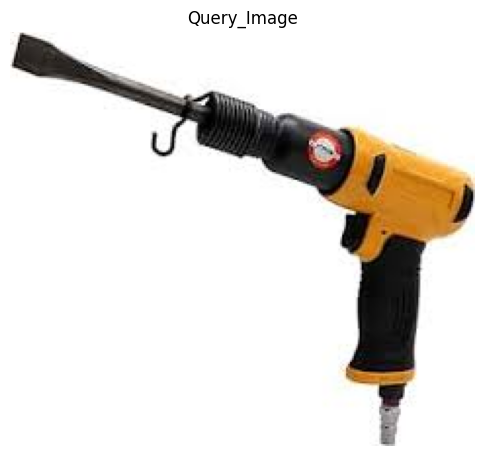

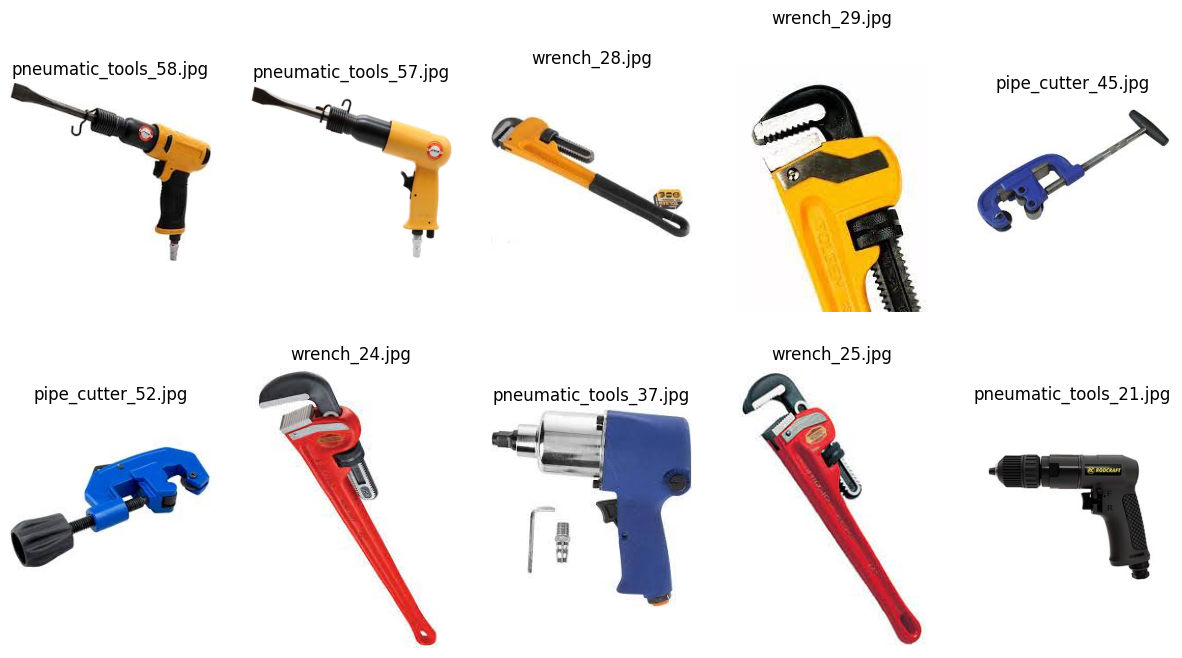

In [40]:
#Set your query image path here
query_image_path = '/home/muftiqur/Work Project/Image-Search-Engine/input_image_10.jpg'
display_query_images_and_similar_images( query_image_path,df_images)

## Fine Tuning CLIP Model

In [16]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip
import pandas as pd
from sqlalchemy import create_engine
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path

In [6]:
image_folder = '/home/muftiqur/Work Project/Image-Search-Engine/Construction_Data'
BATCH_SIZE=16
N_EPOCHS=20
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
import clip
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False)
model.to(DEVICE)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
class Image_Search_Dataset(Dataset):
    """
    Dataset class for an image search task.

    Args:
    - captions (list): A list of captions corresponding to the images.
    - image_tensors (list): A list of image tensors or paths.

    Returns:
    - dictionary: A dictionary containing 'image' and 'caption' for each item in the dataset.
    """
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image = preprocess(Image.open(self.images[idx]))
        caption_idx=self.captions[idx]
        return {'image':image,'caption':caption_idx}
        
    def __len__(self):
        return len(self.captions)

In [40]:
df_images = load_or_create_embeddings(image_folder=image_folder)

list_image_path = list( df_images['image_path'] )
list_txt = list(df_images['label'])


train_dataset = Image_Search_Dataset(list_txt,list_image_path)
tr_dl=DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)

loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)


*****************READ FROM EXISTING EMBEDDINGS***************


In [9]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()

In [10]:
def train_model(n_epochs,train_dataloader,checkpoint_path:str="./checkpoints"):
    """
    Train the model for the specified number of epochs.

    Parameters:
    - n_epochs (int): Number of epochs for training.
    - train_dataloader (DataLoader): DataLoader containing training data.
    - checkpoint_path (str, optional): Path to the directory to save model checkpoints. Defaults to "./checkpoints".

    Returns:
    - model : Trained Model.
    """

    # Create directory for saving checkpoints if it doesn't exist
    if not os.path.isdir(checkpoint_path):
        print("MAKE NEW DIRECTORY")
        os.makedirs(checkpoint_path)

        
    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}


    # Iterate over epochs
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()  # Set model to training mode

        # Iterate over batches in the dataloader
        for step,data in enumerate(train_dataloader,1):
            optimizer.zero_grad()
            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)

            # Forward pass through the model
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)

            labels = torch.arange(len(img_batch)).to(DEVICE) 
            img_loss=loss_img(logits_image,labels)              # Compute image loss
            caption_loss=loss_caption(logits_caption,labels)    # Compute class loss
            total_loss = (img_loss+caption_loss)/2              # Compute total loss
            
            total_loss.backward()
            train_loss+=total_loss.item()

            #Update Model Parameters
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
            total_steps+=1

            scheduler.step() # Adjust Learning Rate
            if (step+1)%20==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")
            
        history['train_loss'].append(train_loss/len(train_dataloader))
        torch.save(model.state_dict(), Path(checkpoint_path)/"best_model.pt")
    return model

In [43]:
trained_model=train_model(N_EPOCHS,tr_dl)

Using cpu for training


  0%|          | 0/20 [00:00<?, ?it/s]/home/muftiqur/Work Project/Image-Search-Engine/CLIPSEARCH/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 20/20 [1:33:43<00:00, 281.18s/it]


In [11]:
import torch
import clip

device = "cuda:0" if torch.cuda.is_available() else "cpu"

checkpoint_path = "/home/muftiqur/Work Project/Image-Search-Engine/checkpoints/best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

model_, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_.load_state_dict(torch.load(Path(checkpoint_path)))
model_.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [30]:
def get_single_image_embedding_from_trained_model(my_image):
    image = preprocess(my_image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model_.encode_image(image)
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

def load_and_prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image


def get_all_images_embedding_from_trained_model(df, img_column):
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding_from_trained_model)
    return df

def add_image_embedding_into_table_testing(image_folder):
    """
    Load images from a folder, compute their embeddings using a trained model, and add the embeddings to a DataFrame.

    Parameters:
    - image_folder (str): The path to the folder containing image files.

    Returns:
    - df_images (pandas.DataFrame): The DataFrame containing image paths, images, and embeddings.
    """
    
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    df_images = pd.DataFrame(image_paths, columns=['image_path'])
    df_images['image'] = df_images['image_path'].apply(load_and_prepare_image)
    df_images = get_all_images_embedding_from_trained_model(df_images, 'image')
    
    return df_images

In [24]:
img_folder = 'Construction_Data' 
df_test = add_image_embedding_into_table_testing(img_folder)

In [28]:
def get_top_N_images_from_trained_model(query, data, top_K, search_criterion):
   query_vect = get_single_image_embedding_from_trained_model(query)
   revevant_cols = ["image","cos_sim","image_path"]
   data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))
   data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
   most_similar_images = data.sort_values(by='cos_sim',  ascending=False)[0:top_K+1]
   return most_similar_images[revevant_cols].reset_index()


def display_query_images_and_similar_images_test(query_image_path,df_images,top_k=10):
    query_image = load_and_prepare_image(query_image_path)
    top_similar_images = get_top_N_images_from_trained_model(query_image, df_images, top_K=top_k, search_criterion="image")
    #unique_categories = top_similar_images['product_category'].unique()
    #print(unique_categories)
    plt.figure(figsize=(4, 5))  
    plt.imshow(query_image)
    plt.title("Query_Image")
    plt.axis('off')
    plot_images_by_side_(top_similar_images)
    plt.show()

**With fine-tuning of the CLIP model, it now successfully retrieves all 10 images from the dataframe, resulting in accurate outcomes.**

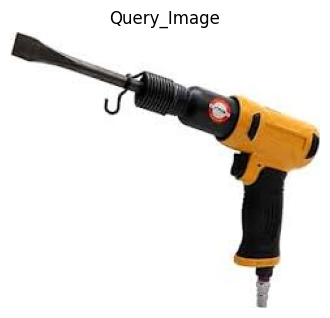

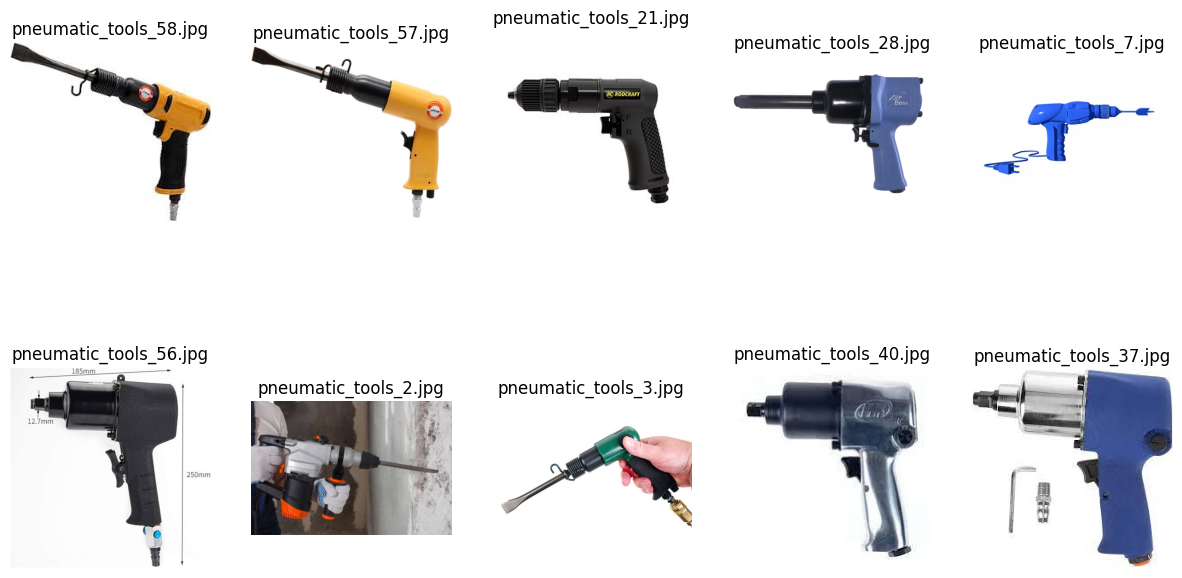

In [31]:
query_image_path = '/home/muftiqur/Work Project/Image-Search-Engine/input_image_10.jpg'
display_query_images_and_similar_images_test( query_image_path,df_test)